<a href="https://colab.research.google.com/github/UoUserusername/bigdataprogrammingH/blob/Ohyeeun/%EB%B9%85%EB%8D%B0%ED%94%84_%EC%97%AC%ED%96%89%EC%BD%98%ED%85%90%EC%B8%A0_%EC%B6%94%EC%B2%9C__%ED%98%91%EC%97%85_%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 협업 필터링 및 콘텐츠 기반 필터링을 활용한 여행 콘텐츠 추천

In [152]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 정확한 경로 설정
base_path = "/content/drive/MyDrive/travel/"

# CSV 불러오기
traveler_df = pd.read_csv(base_path + "tn_traveller_master_여행객 Master_G.csv")
activity_df = pd.read_csv(base_path + "tn_activity_his_활동내역_G.csv")
visit_df = pd.read_csv(base_path + "tn_visit_area_info_방문지정보_G.csv", encoding='utf-8')
travel_df = pd.read_csv(base_path +"tn_travel_여행_G.csv",  encoding='utf-8')
#
consume_df = pd.read_csv(base_path + "tn_activity_consume_his_활동소비내역_G.csv", encoding='utf-8')


# 인코딩 오류 발생 시 아래 코드로 CSV 불러오기 진행 ( 운영체제 차이 )
#traveler_df = pd.read_csv(base_path + "tn_traveller_master_여행객 Master_G.csv", encoding='cp949')
#activity_df = pd.read_csv(base_path + "tn_activity_his_활동내역_G.csv", encoding='cp949')
#visit_df = pd.read_csv(base_path + "tn_visit_area_info_방문지정보_G.csv", encoding='utf-8')
#travel_df = pd.read_csv(base_path +"tn_travel_여행_G.csv",  encoding='utf-8')
#consume_df = pd.read_csv(base_path + "tn_activity_consume_his_활동소비내역_G.csv", encoding='utf-8')

In [154]:
# Step 1. 필요한 컬럼만 선택
consume_df = consume_df[[
    'VISIT_AREA_ID',
    'PAYMENT_DT',
    'PAYMENT_AMT_WON',
    'ROAD_NM_ADDR',
    'STORE_NM',
    'ACTIVITY_TYPE_CD'
]]

# Step 2. VISIT_AREA_ID 타입 정제
consume_df['VISIT_AREA_ID'] = consume_df['VISIT_AREA_ID'].astype(str)

# Step 3. 날짜 파싱 → 계절 생성
consume_df['PAYMENT_DT'] = pd.to_datetime(consume_df['PAYMENT_DT'], errors='coerce')
consume_df['MONTH'] = consume_df['PAYMENT_DT'].dt.month

def get_season(month):
    if pd.isna(month): return None
    if month in [12, 1, 2]: return '겨울'
    elif month in [3, 4, 5]: return '봄'
    elif month in [6, 7, 8]: return '여름'
    else: return '가을'

consume_df['SEASON'] = consume_df['MONTH'].apply(get_season)

# Step 4. REGION 추출
consume_df['REGION'] = consume_df['ROAD_NM_ADDR'].fillna('').str.extract(r'^(\S+도|\S+시|\S+특별시|\S+광역시)')

# Step 5. 요약 계산
consume_summary = (
    consume_df.groupby('VISIT_AREA_ID')
    .agg({
        'PAYMENT_AMT_WON': 'mean',
        'SEASON': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'REGION': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'ACTIVITY_TYPE_CD': lambda x: x.mode().iloc[0] if not x.mode().empty else None
    })
    .reset_index()
    .rename(columns={
        'PAYMENT_AMT_WON': 'AVG_PAYMENT_AMT',
        'SEASON': 'DOMINANT_SEASON',
        'REGION': 'DOMINANT_REGION',
        'ACTIVITY_TYPE_CD': 'MAIN_ACTIVITY_TYPE'
    })
)


<ipython-input-154-1521936126>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consume_df['VISIT_AREA_ID'] = consume_df['VISIT_AREA_ID'].astype(str)
<ipython-input-154-1521936126>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consume_df['PAYMENT_DT'] = pd.to_datetime(consume_df['PAYMENT_DT'], errors='coerce')
<ipython-input-154-1521936126>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [155]:
store_nm_summary = (
    consume_df[['VISIT_AREA_ID', 'STORE_NM']]
    .dropna()
    .groupby('VISIT_AREA_ID')
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

In [156]:

# 활동(Activity) + 여행(TRAVEL) 병합
merged_df = activity_df.merge(travel_df[['TRAVEL_ID', 'TRAVELER_ID']], on='TRAVEL_ID', how='left')

# 사람 정보 병합
merged_df = merged_df.merge(traveler_df, on='TRAVELER_ID', how='left')

merged_df = merged_df.merge(visit_df, on='VISIT_AREA_ID', how='left')
merged_df['VISIT_AREA_ID'] = merged_df['VISIT_AREA_ID'].astype(str)
consume_summary['VISIT_AREA_ID'] = consume_summary['VISIT_AREA_ID'].astype(str)
# refined_df와 병합 (RAM 안전함)
merged_df = merged_df.merge(consume_summary, on='VISIT_AREA_ID', how='left')
merged_df = merged_df.merge(store_nm_summary, on='VISIT_AREA_ID', how='left')


In [157]:
selected_columns = [
    # 여행 ID 및 사용자 ID
    'TRAVEL_ID_x', 'TRAVELER_ID',

    # 사용자 정보
    'AGE_GRP', 'GENDER', 'INCOME', 'HOUSE_INCOME',
    'FAMILY_MEMB', 'TRAVEL_COMPANIONS_NUM', 'TRAVEL_TERM',

    # 여행 성향 (존재하는 스타일 및 선호 지역)
    'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SGG_1',
    'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3',
    'TRAVEL_MOTIVE_1','TRAVEL_MOTIVE_2','TRAVEL_MOTIVE_3',

    # 활동 정보
    'ACTIVITY_TYPE_CD', 'ACTIVITY_DTL', 'ACTIVITY_ETC',
    'EXPND_SE', 'RSVT_YN', 'ADMISSION_SE',

    # 방문지 정보
    'VISIT_AREA_ID', 'VISIT_AREA_NM', 'ROAD_NM_ADDR', 'LOTNO_ADDR',
    'X_COORD', 'Y_COORD', 'RESIDENCE_TIME_MIN', 'REVISIT_INTENTION',

     # VISIT_AREA_ID 기반 소비 요약
    'AVG_PAYMENT_AMT',
    'DOMINANT_SEASON',
    'DOMINANT_REGION',
    'MAIN_ACTIVITY_TYPE',

    # STORE_NM
    'STORE_NM',

    'TRAVEL_STATUS_ACCOMPANY'
]


In [158]:
refined_df = merged_df[selected_columns].drop_duplicates()


In [159]:
refined_df.to_csv("/content/drive/MyDrive/travel/필터링용_데이터.csv", index=False)

In [160]:
refined_df.head()


,TRAVEL_ID_x,TRAVELER_ID,AGE_GRP,GENDER,INCOME,HOUSE_INCOME,FAMILY_MEMB,TRAVEL_COMPANIONS_NUM,TRAVEL_TERM,TRAVEL_LIKE_SIDO_1,...,X_COORD,Y_COORD,RESIDENCE_TIME_MIN,REVISIT_INTENTION,AVG_PAYMENT_AMT,DOMINANT_SEASON,DOMINANT_REGION,MAIN_ACTIVITY_TYPE,STORE_NM,TRAVEL_STATUS_ACCOMPANY
0,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,127.425684,36.439598,30.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
1,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.854664,36.962309,90.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
2,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.287070,36.619450,30.0,2.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
3,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.291159,36.607067,780.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
4,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.990157,36.398710,30.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행


In [161]:
# 1. 삭제해도 되는 열 제거
refined_df = refined_df.drop(columns=['ACTIVITY_ETC', 'ADMISSION_SE'])

# 3. 범주형 - 결측치를 '미기재' 등으로 채우기
refined_df['ACTIVITY_DTL'] = refined_df['ACTIVITY_DTL'].fillna('미기재')
refined_df['TRAVEL_MOTIVE_2'] = refined_df['TRAVEL_MOTIVE_2'].fillna('미기재')
refined_df['TRAVEL_MOTIVE_3'] = refined_df['TRAVEL_MOTIVE_3'].fillna('미기재')
refined_df['REVISIT_INTENTION'] = refined_df['REVISIT_INTENTION'].fillna('미기재')
refined_df['RESIDENCE_TIME_MIN'] = refined_df['RESIDENCE_TIME_MIN'].fillna(0)

In [162]:
user_counts = refined_df['TRAVELER_ID'].value_counts()
refined_df = refined_df[refined_df['TRAVELER_ID'].isin(user_counts[user_counts >= 3].index)]

item_counts = refined_df['VISIT_AREA_NM'].value_counts()
refined_df = refined_df[refined_df['VISIT_AREA_NM'].isin(item_counts[item_counts >= 3].index)]


In [163]:
print(refined_df[['TRAVEL_COMPANIONS_NUM', 'RESIDENCE_TIME_MIN']].dtypes)


TRAVEL_COMPANIONS_NUM      int64
RESIDENCE_TIME_MIN       float64
dtype: object


In [164]:
# traveler_id 기준으로 활동 이력을 리스트화
user_activity_map = refined_df.groupby('TRAVELER_ID')['ACTIVITY_TYPE_CD'].apply(list)

In [165]:
# 결과 저장
refined_df.to_csv("/content/drive/MyDrive/travel/command_data.csv", index=False)


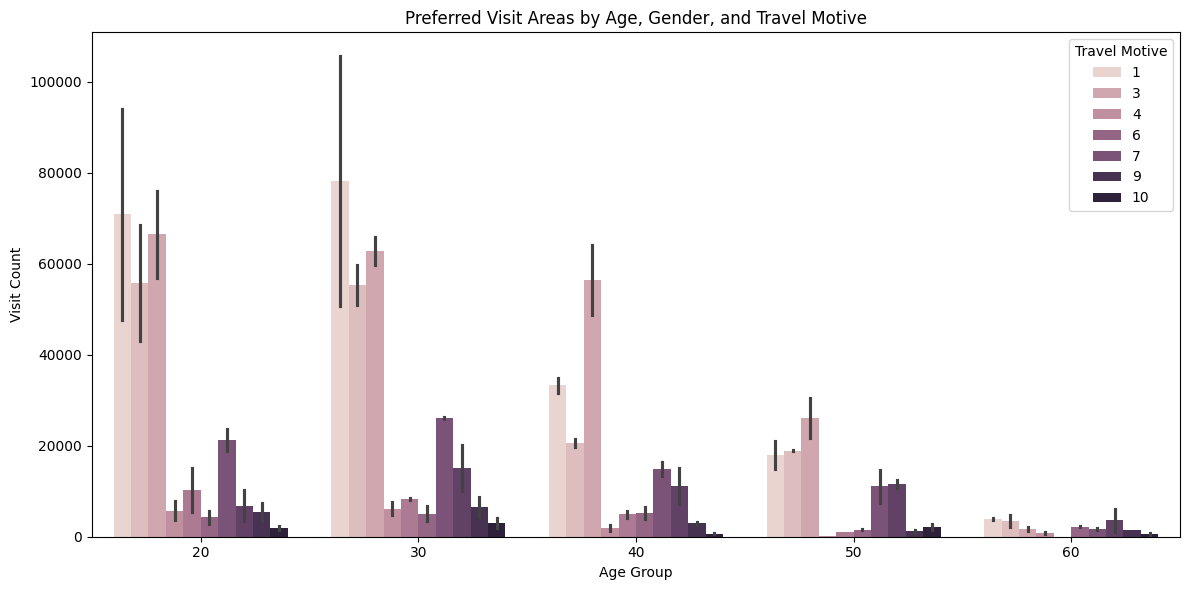

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = refined_df.groupby(['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1'])['VISIT_AREA_NM'].count().reset_index()
grouped.rename(columns={'VISIT_AREA_NM': 'visit_count'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='AGE_GRP', y='visit_count', hue='TRAVEL_MOTIVE_1')
plt.title('Preferred Visit Areas by Age, Gender, and Travel Motive')
plt.xlabel('Age Group')
plt.ylabel('Visit Count')
plt.legend(title='Travel Motive')
plt.tight_layout()
plt.show()


In [167]:
# 고유값(unique) 확인
print("여행 스타일 (TRAVEL_STYL_1):")
print(refined_df['TRAVEL_STYL_1'].dropna().unique())

print("\n여행 동기 (TRAVEL_MOTIVE_1):")
print(refined_df['TRAVEL_MOTIVE_1'].dropna().unique())

# 값별 개수 확인
print("여행 스타일 (TRAVEL_STYL_1) - 값 분포:")
print(refined_df['TRAVEL_STYL_1'].value_counts())

print("\n여행 동기 (TRAVEL_MOTIVE_1) - 값 분포:")
print(refined_df['TRAVEL_MOTIVE_1'].value_counts())


여행 스타일 (TRAVEL_STYL_1):
[4 7 1 5 2 3 6]

여행 동기 (TRAVEL_MOTIVE_1):
[ 7  2  3  1  9  5  8  4  6 10]
여행 스타일 (TRAVEL_STYL_1) - 값 분포:
TRAVEL_STYL_1
2    419064
4    336914
1    301254
3    209818
6    121724
5    104096
7     61979
Name: count, dtype: int64

여행 동기 (TRAVEL_MOTIVE_1) - 값 분포:
TRAVEL_MOTIVE_1
3     427118
1     408007
2     308260
7     149906
8      96440
5      48833
6      36425
9      33686
4      29505
10     16669
Name: count, dtype: int64


In [168]:
# 미기재 제거 (정확하게 모든 관련 컬럼에 대해 적용)
for col in ['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN']:
    refined_df = refined_df[~refined_df[col].astype(str).str.contains('미기재', na=False)]
    refined_df[col] = pd.to_numeric(refined_df[col], errors='coerce')

# 그 외 숫자형 컬럼도 전처리
refined_df['TRAVEL_COMPANIONS_NUM'] = pd.to_numeric(refined_df['TRAVEL_COMPANIONS_NUM'], errors='coerce')

# 최종 NaN 제거
refined_df = refined_df.dropna(subset=['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN', 'TRAVEL_COMPANIONS_NUM'])


콘텐츠 기반 필터링을 활용하여 사용자에게 맞춤형 여행지를 추천

In [169]:
# 콘텐츠 기반 필터링
# 필수 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# 데이터 정제 (REVISIT_INTENTION, RESIDENCE_TIME_MIN 숫자화 및 NaN 제거)
refined_df = refined_df[~refined_df['REVISIT_INTENTION'].astype(str).str.contains('미기재')]
refined_df = refined_df[~refined_df['RESIDENCE_TIME_MIN'].astype(str).str.contains('미기재')]
refined_df['REVISIT_INTENTION'] = pd.to_numeric(refined_df['REVISIT_INTENTION'], errors='coerce')
refined_df['RESIDENCE_TIME_MIN'] = pd.to_numeric(refined_df['RESIDENCE_TIME_MIN'], errors='coerce')
refined_df = refined_df.dropna(subset=['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN'])

# 사용할 피처 정의
categorical_cols = ['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1', 'TRAVEL_STYL_1','TRAVEL_STATUS_ACCOMPANY']
numeric_cols = ['TRAVEL_COMPANIONS_NUM', 'RESIDENCE_TIME_MIN', 'REVISIT_INTENTION']

features_label = [
    'AGE_GRP_LABEL', 'GENDER_LABEL', 'TRAVEL_COMPANIONS_NUM',
    'TRAVEL_MOTIVE_1_LABEL', 'TRAVEL_STYL_1_LABEL',
    'REVISIT_INTENTION', 'TRAVEL_STATUS_ACCOMPANY_LABEL'
]

# LabelEncoder 인코딩 (원본 보존, _LABEL 붙여 저장)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    refined_df[col + '_LABEL'] = le.fit_transform(refined_df[col].astype(str))
    label_encoders[col] = le

# 5. 사용자 입력 (3개만)
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2,
    'TRAVEL_STYL_1': 4,
    'TRAVEL_MOTIVE_1': 3,
    'TRAVEL_STATUS_ACCOMPANY': '2인 여행(가족 외)'
}

# 6. 조건 만족하는 유저 필터링
# 필수 조건
base_cond = (
    (refined_df['AGE_GRP_LABEL'] == label_encoders['AGE_GRP'].transform([user_input['AGE_GRP']])[0]) &
    (refined_df['GENDER_LABEL'] == label_encoders['GENDER'].transform([user_input['GENDER']])[0]) &
    (refined_df['TRAVEL_COMPANIONS_NUM'] == user_input['TRAVEL_COMPANIONS_NUM'])
)

# 선택 조건
opt1 = refined_df['TRAVEL_MOTIVE_1_LABEL'] == user_input['TRAVEL_MOTIVE_1']
opt2 = refined_df['TRAVEL_STYL_1_LABEL'].between(user_input['TRAVEL_STYL_1'] - 1, user_input['TRAVEL_STYL_1'] + 1)
opt3 = refined_df['TRAVEL_STATUS_ACCOMPANY'] == user_input['TRAVEL_STATUS_ACCOMPANY']

# 선택 조건 중 하나 이상 만족
optional_cond = (opt1.astype(int) + opt2.astype(int) + opt3.astype(int)) >= 1

# 최종 필터링
filtered_df = refined_df[base_cond & optional_cond]


# fallback 처리: 만족하는 조건 없으면 전체에서 평균/최빈값 사용
if filtered_df.empty:
    filtered_df = refined_df.copy()

mean_row = filtered_df[numeric_cols].mean()
mode_row = filtered_df[[col + '_LABEL' for col in categorical_cols]].mode().iloc[0]


# user_vector 생성 (총 8차원)
user_vector = np.array([[
    label_encoders['AGE_GRP'].transform([user_input['AGE_GRP']])[0],
    label_encoders['GENDER'].transform([user_input['GENDER']])[0],
    user_input['TRAVEL_COMPANIONS_NUM'],
    user_input['TRAVEL_MOTIVE_1'],
    user_input['TRAVEL_STYL_1'],
    label_encoders['TRAVEL_STATUS_ACCOMPANY'].transform([user_input['TRAVEL_STATUS_ACCOMPANY']])[0],
    mean_row['REVISIT_INTENTION']
]])

# 장소 벡터 구성 (mean aggregation)
grouped = refined_df.groupby('VISIT_AREA_NM')[features_label].mean().reset_index()

#추가 # 지역 정보(도로명 주소) 병합
area_address_df = refined_df[['VISIT_AREA_NM', 'ROAD_NM_ADDR']].dropna().drop_duplicates(subset='VISIT_AREA_NM')
grouped = grouped.merge(area_address_df, on='VISIT_AREA_NM', how='left')

grouped = grouped[grouped['REVISIT_INTENTION'] >= 3.5]
# 정규화 + 유사도 계산
combined = np.vstack([user_vector, grouped[features_label].values])
scaled = StandardScaler().fit_transform(combined)
user_scaled = scaled[0].reshape(1, -1)
places_scaled = scaled[1:]

weights = np.array([1, 1, 1, 0.8, 0.6, 0.6, 1])  # features_label 순서에 맞춰 가중치 지정

user_scaled_weighted = user_scaled * weights
places_scaled_weighted = places_scaled * weights

similarities = cosine_similarity(user_scaled_weighted, places_scaled_weighted)[0]
grouped['similarity'] = similarities

# 추천 결과 출력
top_recommendations = grouped.sort_values(by='similarity', ascending=False).head(10)

for idx, row in top_recommendations.iterrows():
    print(f" 추천 장소: {row['VISIT_AREA_NM']}")
    print(f"   - 지역: {row['ROAD_NM_ADDR']}")
    print(f"   - 유사도: {row['similarity']:.3f}")
    print(f"   - 재방문 의향: {row['REVISIT_INTENTION']:.1f}점\n")


 추천 장소: 슬픈 연가 촬영지
   - 지역: nan
   - 유사도: 0.933
   - 재방문 의향: 4.0점

 추천 장소: 신선한 아틀리에
   - 지역: 충남 보령시 해수욕장4길 76
   - 유사도: 0.883
   - 재방문 의향: 4.0점

 추천 장소: 다온 편백
   - 지역: 전남 여수시 웅천남6로 21
   - 유사도: 0.883
   - 재방문 의향: 4.0점

 추천 장소: 카리 코
   - 지역: 대전 유성구 엑스포로151번길 19
   - 유사도: 0.882
   - 재방문 의향: 4.0점

 추천 장소: 순천 전통야생차체험관
   - 지역: 전남 순천시 승주읍 선암사길 450-1
   - 유사도: 0.876
   - 재방문 의향: 4.0점

 추천 장소: 여수 요트 수상 레저
   - 지역: 전남 여수시 돌산읍 진모1길 58
   - 유사도: 0.876
   - 재방문 의향: 4.0점

 추천 장소: 국립청주박물관
   - 지역: 충북 청주시 상당구 명암로 143
   - 유사도: 0.876
   - 재방문 의향: 4.0점

 추천 장소: 전일빌딩 245
   - 지역: 광주 동구 금남로 245
   - 유사도: 0.869
   - 재방문 의향: 4.1점

 추천 장소: 치히로 군산 월명점
   - 지역: 전북 군산시 구영5길 81
   - 유사도: 0.861
   - 재방문 의향: 4.0점

 추천 장소: 대천해수욕장 3지구 제1공영주차장
   - 지역: nan
   - 유사도: 0.853
   - 재방문 의향: 4.2점



**1. Uer-Based 협업 필터링 기법을 활용하여 사용자의 여행 성향과 유사한 사람들을 기반으로 여행지를 추천하는 시스템**

1-1.
유사 사용자 선택 시, 단순히 AGE_GRP, GENDER, TRAVEL_COMPANIONS_NUM 3가지 조건에 맞는 사용자 중, REVISIT_INTENTION을 기반으로 유사 사용자 찾고 예측

In [170]:
# 사용자 기반 협업 필터링
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 유저-장소 평점 데이터 생성
interaction_df = refined_df[['TRAVELER_ID', 'VISIT_AREA_NM', 'REVISIT_INTENTION']].dropna()
user_item_matrix = interaction_df.pivot_table(index='TRAVELER_ID', columns='VISIT_AREA_NM', values='REVISIT_INTENTION')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_sim = cosine_similarity(user_item_matrix_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

# 사용자 입력 정보
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

# 입력 조건과 가장 유사한 유저 찾기
def find_most_similar_user(refined_df, user_input):
    filtered = refined_df[
        (refined_df['AGE_GRP'].astype(str) == user_input['AGE_GRP']) &
        (refined_df['GENDER'] == user_input['GENDER']) &
        (refined_df['TRAVEL_COMPANIONS_NUM'] == user_input['TRAVEL_COMPANIONS_NUM'])
    ]
    if filtered.empty:
        print("조건에 맞는 사용자가 없습니다. 전체 중 임의 사용자로 추천합니다.")
        return refined_df['TRAVELER_ID'].iloc[0]
    else:
        return filtered['TRAVELER_ID'].value_counts().idxmax()

# 추천 함수 정의
def recommend_places_for_user(target_user_id, top_n=5):
    if target_user_id not in user_item_matrix.index:
        print("존재하지 않는 사용자입니다.")
        return

    # 1. 유사 사용자 선택
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)
    similar_users = sim_scores.sort_values(ascending=False).head(5)
    similar_users = similar_users[similar_users > 0]  # 유사도가 0보다 큰 사용자만 사용

    # 2. 예측 평점 계산
    predictions = {}
    for place in user_item_matrix.columns:
        if not pd.isna(user_item_matrix.loc[target_user_id, place]):
            continue  # 이미 방문한 장소는 제외

        numer = 0.0
        denom = 0.0
        contributing = []

        for other_user_id, sim_score in similar_users.items():
            rating = user_item_matrix.loc[other_user_id, place]
            if not pd.isna(rating) and rating > 0:
                numer += sim_score * rating
                denom += sim_score
                contributing.append(sim_score)

        if denom > 0:
            pred_score = numer / denom
            avg_similarity = np.mean(contributing)
            predictions[place] = (pred_score, avg_similarity)

    # 3. 예측 평점 기준으로 추천
    top_recommendations = sorted(predictions.items(), key=lambda x: x[1][0], reverse=True)[:top_n]

    # 4. 출력
    for place, (score, avg_similarity) in top_recommendations:
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]
        avg_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit = place_data['REVISIT_INTENTION'].mean()

        print(f"추천 장소: {place}")
        print(f"  - 예측 평점: {score:.2f}")
        print(f"  - 기여 유사도: {avg_similarity:.3f}")
        print(f"  - 평균 체류 시간: {avg_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit:.1f}점\n")

# 실행
target_user_id = find_most_similar_user(refined_df, user_input)
recommend_places_for_user(target_user_id=target_user_id, top_n=5)


추천 장소: The 대단한 커피 x 대단한 탕후루 대전은행점
  - 예측 평점: 5.00
  - 기여 유사도: 0.949
  - 평균 체류 시간: 0.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 금강로하스공원 주차장
  - 예측 평점: 5.00
  - 기여 유사도: 0.949
  - 평균 체류 시간: 30.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 다이와 회전 초밥
  - 예측 평점: 5.00
  - 기여 유사도: 0.949
  - 평균 체류 시간: 30.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 라한 호텔 전주
  - 예측 평점: 5.00
  - 기여 유사도: 0.954
  - 평균 체류 시간: 218.3분
  - 평균 재방문 의향: 4.9점

추천 장소: 범맥주 여수 학동점
  - 예측 평점: 5.00
  - 기여 유사도: 0.949
  - 평균 체류 시간: 30.0분
  - 평균 재방문 의향: 5.0점



1-2.
라벨 인코딩을 통해 **사용자 특성(나이, 성별, 여행 스타일, 여행 동기, 동행자 관계 등)**을 숫자로 변환 후 match_score라는 점수를 통해 다양한 특성 유사도를 가중합으로 고려

In [171]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

# 1. 사용자-장소 평점 행렬 생성 함수
def create_user_item_matrix(df):
    interaction_df = df[['TRAVELER_ID', 'VISIT_AREA_NM', 'REVISIT_INTENTION']].dropna()
    user_item = interaction_df.pivot_table(
        index='TRAVELER_ID', columns='VISIT_AREA_NM', values='REVISIT_INTENTION'
    ).fillna(0)
    return user_item

# 2. 라벨 인코딩 (user_input 포함)
def encode_categorical_columns(df, user_input, categorical_cols):
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        combined = df[col].astype(str).tolist() + [str(user_input[col])]
        le.fit(combined)
        df[col + '_LABEL'] = le.transform(df[col].astype(str))
        label_encoders[col] = le
    return df, label_encoders

# 3. Top-K 유사 사용자 찾기
def find_top_k_similar_users(df, user_input, label_encoders, k=20):
    df = df.copy()
    df['match_score'] = 0.0

    # 각 항목별 매칭 점수 계산
    if 'AGE_GRP' in label_encoders:
        age_label = label_encoders['AGE_GRP'].transform([user_input['AGE_GRP']])[0]
        df.loc[df['AGE_GRP_LABEL'] == age_label, 'match_score'] += 1

    if 'GENDER' in label_encoders:
        gender_label = label_encoders['GENDER'].transform([user_input['GENDER']])[0]
        df.loc[df['GENDER_LABEL'] == gender_label, 'match_score'] += 1

    companions_diff = abs(df['TRAVEL_COMPANIONS_NUM'] - user_input['TRAVEL_COMPANIONS_NUM'])
    df.loc[companions_diff == 0, 'match_score'] += 1
    df.loc[companions_diff == 1, 'match_score'] += 0.5

    motive_label = label_encoders['TRAVEL_MOTIVE_1'].transform([str(user_input['TRAVEL_MOTIVE_1'])])[0]
    df.loc[df['TRAVEL_MOTIVE_1_LABEL'] == motive_label, 'match_score'] += 1

    style_label = label_encoders['TRAVEL_STYL_1'].transform([str(user_input['TRAVEL_STYL_1'])])[0]
    df.loc[df['TRAVEL_STYL_1_LABEL'] == style_label, 'match_score'] += 1

    accompany_label = label_encoders['TRAVEL_STATUS_ACCOMPANY'].transform([user_input['TRAVEL_STATUS_ACCOMPANY']])[0]
    df.loc[df['TRAVEL_STATUS_ACCOMPANY_LABEL'] == accompany_label, 'match_score'] += 1

    top_users = df.sort_values(by='match_score', ascending=False)['TRAVELER_ID'].unique()[:k]
    return top_users

# 4. 유사 사용자 기반 추천 함수
def recommend_places_from_users(top_users, user_item_matrix, refined_df, top_n=5):
    weighted_scores = pd.Series(dtype=float)
    for user_id in top_users:
        if user_id not in user_item_matrix.index:
            continue
        ratings = user_item_matrix.loc[user_id]
        weighted_scores = weighted_scores.add(ratings, fill_value=0)

    # 평균 내기 (유사 사용자 수로 나눔)
    weighted_scores = weighted_scores / len(top_users)

    top_recommendations = weighted_scores.sort_values(ascending=False).head(top_n)

    for place, score in top_recommendations.items():
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]
        avg_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit = place_data['REVISIT_INTENTION'].mean()

        print(f"추천 장소: {place}")
        print(f"  - 예측 평점: {score:.2f}")
        print(f"  - 평균 체류 시간: {avg_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit:.2f}점\n")

# 5. 실행 함수
def main(refined_df, user_input):
    categorical_cols = ['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1', 'TRAVEL_STYL_1', 'TRAVEL_STATUS_ACCOMPANY']
    df_encoded, label_encoders = encode_categorical_columns(refined_df.copy(), user_input, categorical_cols)

    user_item = create_user_item_matrix(df_encoded)
    top_users = find_top_k_similar_users(df_encoded, user_input, label_encoders, k=10)

    print(f"\n선택된 유사 사용자 수: {len(top_users)}\n")
    recommend_places_from_users(top_users, user_item, refined_df, top_n=6)

# 사용자 입력 예시
user_input = {
    'AGE_GRP': '20',
    'GENDER': '남',
    'TRAVEL_COMPANIONS_NUM': 2,
    'TRAVEL_STYL_1': 5,
    'TRAVEL_MOTIVE_1': 3,
    'TRAVEL_STATUS_ACCOMPANY': '2인 여행 가족(외)'
}

# 실행
main(refined_df, user_input)



선택된 유사 사용자 수: 10

추천 장소: 성심당 본점
  - 예측 평점: 4.66
  - 평균 체류 시간: 43.0분
  - 평균 재방문 의향: 4.56점

추천 장소: 한밭수목원
  - 예측 평점: 4.03
  - 평균 체류 시간: 64.3분
  - 평균 재방문 의향: 4.44점

추천 장소: 독립기념관
  - 예측 평점: 3.82
  - 평균 체류 시간: 120.0분
  - 평균 재방문 의향: 4.75점

추천 장소: 성심당 케이크 부티크
  - 예측 평점: 3.68
  - 평균 체류 시간: 18.6분
  - 평균 재방문 의향: 4.35점

추천 장소: 대전역
  - 예측 평점: 3.52
  - 평균 체류 시간: 22.3분
  - 평균 재방문 의향: 4.38점

추천 장소: 채석강
  - 예측 평점: 3.25
  - 평균 체류 시간: 66.4분
  - 평균 재방문 의향: 4.44점



**2. 협업 필터링 기반 숙박 장소 추천 시스템**

In [172]:
refined_df[refined_df['VISIT_AREA_NM'].str.contains('펜션|숙소|게스트하우스|호텔|리조트', na=False)]


,TRAVEL_ID_x,TRAVELER_ID,AGE_GRP,GENDER,INCOME,HOUSE_INCOME,FAMILY_MEMB,TRAVEL_COMPANIONS_NUM,TRAVEL_TERM,TRAVEL_LIKE_SIDO_1,...,DOMINANT_SEASON,DOMINANT_REGION,MAIN_ACTIVITY_TYPE,STORE_NM,TRAVEL_STATUS_ACCOMPANY,AGE_GRP_LABEL,GENDER_LABEL,TRAVEL_MOTIVE_1_LABEL,TRAVEL_STYL_1_LABEL,TRAVEL_STATUS_ACCOMPANY_LABEL
9,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행,1,1,7,3,0
14,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,봄,None,1.0,NC 청주점,2인 가족 여행,1,1,7,3,0
19,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,봄,None,1.0,Largo,2인 가족 여행,1,1,7,3,0
98,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,봄,None,1.0,(주)코마린(카누&카약&보트),2인 가족 여행,1,1,7,3,0
99,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,봄,None,1.0,3 섬광,2인 가족 여행,1,1,7,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568160,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,여름,제주특별자치도,1.0,천안호두(부산)휴게소,나홀로 여행,2,1,4,0,5
1568194,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,여름,None,1.0,경기전,나홀로 여행,2,1,4,0,5
1568198,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,여름,None,1.0,경기전,나홀로 여행,2,1,4,0,5
1568199,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,여름,None,1.0,경기전,나홀로 여행,2,1,4,0,5


In [173]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 사용자 입력
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

# 1. 사용자-장소 평점 행렬 만들기
user_item_matrix = refined_df.pivot_table(
    index='TRAVELER_ID',
    columns='VISIT_AREA_NM',
    values='REVISIT_INTENTION'
)

# NaN → 0으로 채워 코사인 유사도 계산
filled_matrix = user_item_matrix.fillna(0)

# 2. 입력값 기반으로 유사 사용자 Top-K 선택 (특징 기반 matching)
def find_top_k_users(refined_df, user_input, k=10):
    df = refined_df.copy()
    df['match_score'] = 0.0

    df.loc[df['AGE_GRP'].astype(str) == str(user_input['AGE_GRP']), 'match_score'] += 1
    df.loc[df['GENDER'] == user_input['GENDER'], 'match_score'] += 1

    df['TRAVEL_COMPANIONS_NUM'] = pd.to_numeric(df['TRAVEL_COMPANIONS_NUM'], errors='coerce')
    companions_diff = np.abs(df['TRAVEL_COMPANIONS_NUM'] - user_input['TRAVEL_COMPANIONS_NUM'])
    df.loc[companions_diff == 0, 'match_score'] += 1
    df.loc[companions_diff == 1, 'match_score'] += 0.5

    top_users = df.sort_values(by='match_score', ascending=False)['TRAVELER_ID'].unique()[:k]
    return top_users

# 3. 추천 함수 (입력값 기준 유사 사용자 기반 추천)

def recommend_places_from_users(user_ids, user_sim_df, user_item_matrix, refined_df, top_n=5):
    accommodation_keywords = ['펜션', '숙소', '게스트하우스', '호텔', '리조트']
    place_sim_scores = {}

    for target_user_id in user_ids:
        if target_user_id not in user_sim_df.index:
            continue

        sim_scores = user_sim_df.loc[target_user_id].drop(target_user_id)
        similar_users = sim_scores[sim_scores > 0]

        for uid, sim in similar_users.items():
            visited_places = user_item_matrix.loc[uid]
            visited_places = visited_places[visited_places > 0].index
            for place in visited_places:
                if any(keyword in place for keyword in accommodation_keywords):
                    if place not in place_sim_scores:
                        place_sim_scores[place] = []
                    place_sim_scores[place].append(sim)

    if not place_sim_scores:
        print("추천할 숙소 관련 장소가 없습니다.")
        return

    # 유사도 평균 계산 및 정렬
    avg_sim_scores = {place: np.mean(sims) for place, sims in place_sim_scores.items()}
    top_places = sorted(avg_sim_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"\n 추천 기준 사용자 IDs: {', '.join(user_ids)}\n")
    for place, sim_score in top_places:
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]
        avg_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit = place_data['REVISIT_INTENTION'].mean()

        print(f"추천 장소: {place}")
        print(f"  - 유사도 평균: {sim_score:.3f}")
        print(f"  - 평균 체류 시간: {avg_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit:.2f}점\n")



# 4. 실행
similar_users = find_top_k_users(refined_df, user_input, k=5)
recommend_places_from_users(similar_users, user_sim_df, user_item_matrix, refined_df, top_n=9)



 추천 기준 사용자 IDs: g001129, g005225, g013084, g005012, g006287

추천 장소: 달링하버 펜션
  - 유사도 평균: 0.208
  - 평균 체류 시간: 230.0분
  - 평균 재방문 의향: 5.00점

추천 장소: 나비잠 한옥 호텔
  - 유사도 평균: 0.207
  - 평균 체류 시간: 1440.0분
  - 평균 재방문 의향: 4.00점

추천 장소: NU 호텔
  - 유사도 평균: 0.207
  - 평균 체류 시간: 270.0분
  - 평균 재방문 의향: 5.00점

추천 장소: 안단테 스파펜션
  - 유사도 평균: 0.206
  - 평균 체류 시간: 360.0분
  - 평균 재방문 의향: 3.00점

추천 장소: 꽃들의 물감 찾기 펜션
  - 유사도 평균: 0.204
  - 평균 체류 시간: 510.0분
  - 평균 재방문 의향: 5.00점

추천 장소: 호텔 브라운 도트
  - 유사도 평균: 0.204
  - 평균 체류 시간: 390.0분
  - 평균 재방문 의향: 5.00점

추천 장소: 고흥썬밸리리조트
  - 유사도 평균: 0.203
  - 평균 체류 시간: 300.0분
  - 평균 재방문 의향: 3.00점

추천 장소: 수안보 상록호텔 온천사우나
  - 유사도 평균: 0.203
  - 평균 체류 시간: 90.0분
  - 평균 재방문 의향: 3.00점

추천 장소: 호텔 루나
  - 유사도 평균: 0.202
  - 평균 체류 시간: 60.0분
  - 평균 재방문 의향: 5.00점



**3. 협업 필터링 기반 음식점 추천 시스템**

In [174]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 0. 사용자 입력값 정의
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

# 1. 음식점만 필터링
food_df = refined_df[
    (refined_df['MAIN_ACTIVITY_TYPE'] == 1) &
    (refined_df['STORE_NM'].notna())
].copy()

if food_df.empty:
    print("음식점 데이터가 없습니다. 전체에서 추천합니다.")
    food_df = refined_df.copy()

# 2. 유사 사용자 10명 찾기 (입력값 기반)
def find_similar_users(df, user_input, k=10):
    df = df.copy()
    df['match_score'] = 0.0

    df.loc[df['AGE_GRP'].astype(str) == str(user_input['AGE_GRP']), 'match_score'] += 1
    df.loc[df['GENDER'] == user_input['GENDER'], 'match_score'] += 1

    df['TRAVEL_COMPANIONS_NUM'] = pd.to_numeric(df['TRAVEL_COMPANIONS_NUM'], errors='coerce')
    diff = np.abs(df['TRAVEL_COMPANIONS_NUM'] - user_input['TRAVEL_COMPANIONS_NUM'])
    df.loc[diff == 0, 'match_score'] += 1
    df.loc[diff == 1, 'match_score'] += 0.5

    top_users = df.sort_values(by='match_score', ascending=False)['TRAVELER_ID'].unique()[:k]
    return top_users

similar_users = find_similar_users(food_df, user_input, k=10)

# 3. 사용자-음식점 평점 행렬
user_item_matrix = food_df.pivot_table(
    index='TRAVELER_ID',
    columns='STORE_NM',
    values='REVISIT_INTENTION'
).fillna(0)

# 4. 유사 사용자들끼리 유사도 행렬 계산
user_similarity = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# 5. 음식점 평점 예측
weights = {}
for uid in similar_users:
    if uid not in user_item_matrix.index:
        continue
    for store, score in user_item_matrix.loc[uid].items():
        if score == 0:
            continue
        if store not in weights:
            weights[store] = []
        weights[store].append(score)

# 6. 평균 점수 계산 및 상위 5개 추천
avg_scores = {store: np.mean(scores) for store, scores in weights.items()}
top_stores = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:6]

# 7. 출력

print("추천 음식점 결과\n")
for store, score in top_stores:
    info = food_df[food_df['STORE_NM'] == store].iloc[0]
    print(f"추천 음식점: {store}-{info['VISIT_AREA_NM']}")
    print(f"  - 유사 사용자 기반 평균 평점: {score:.2f}\n")



추천 음식점 결과

추천 음식점: NC웨이브-시골 통닭
  - 유사 사용자 기반 평균 평점: 4.64

추천 음식점: (주)메타45카페-센트럴시티터미널(호남)
  - 유사 사용자 기반 평균 평점: 4.57

추천 음식점: 영인산 자연휴양림-장원 막국수
  - 유사 사용자 기반 평균 평점: 4.54

추천 음식점: 로쏘주식회사 테라스키친-진우네 집 국수
  - 유사 사용자 기반 평균 평점: 4.44

추천 음식점: 고운뜰 공방카페-꽃지 레포츠
  - 유사 사용자 기반 평균 평점: 4.38

추천 음식점: 레이크힐 제빵소-롯데리조트 부여
  - 유사 사용자 기반 평균 평점: 4.36



In [175]:
# 콘텐츠 기반 필터링 평가
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_specific_user_group(refined_df, user_filter, top_k=5):
    # 1. 데이터 정제
    refined_df = refined_df[~refined_df['REVISIT_INTENTION'].astype(str).str.contains('미기재')]
    refined_df = refined_df[~refined_df['RESIDENCE_TIME_MIN'].astype(str).str.contains('미기재')]
    refined_df['REVISIT_INTENTION'] = pd.to_numeric(refined_df['REVISIT_INTENTION'], errors='coerce')
    refined_df['RESIDENCE_TIME_MIN'] = pd.to_numeric(refined_df['RESIDENCE_TIME_MIN'], errors='coerce')
    refined_df = refined_df.dropna(subset=['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN'])

    # 2. 인코딩
    categorical_cols = ['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1', 'TRAVEL_STYL_1', 'TRAVEL_STATUS_ACCOMPANY']
    features_label = [
        'AGE_GRP_LABEL', 'GENDER_LABEL', 'TRAVEL_COMPANIONS_NUM',
        'TRAVEL_MOTIVE_1_LABEL', 'TRAVEL_STYL_1_LABEL',
        'REVISIT_INTENTION', 'TRAVEL_STATUS_ACCOMPANY_LABEL'
    ]
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        refined_df[col] = refined_df[col].astype(str)
        refined_df[col + '_LABEL'] = le.fit_transform(refined_df[col])
        label_encoders[col] = le

    # 3. 해당 조건에 맞는 사용자 추출
    matched_users = refined_df[
        (refined_df['AGE_GRP'] == user_filter['AGE_GRP']) &
        (refined_df['GENDER'] == user_filter['GENDER']) &
        (refined_df['TRAVEL_COMPANIONS_NUM'] == user_filter['TRAVEL_COMPANIONS_NUM'])
    ]['TRAVELER_ID'].unique()

    print(f" 조건에 맞는 사용자 수: {len(matched_users)}")

    # 4. user_vector 생성 (TRAVEL_MOTIVE_1, STYL, ACCOMPANY는 평균 사용)
    filtered_df = refined_df[refined_df['TRAVELER_ID'].isin(matched_users)]
    if filtered_df.empty:
        return 0

    mean_row = filtered_df[['REVISIT_INTENTION']].mean()
    mode_row = filtered_df[[col + '_LABEL' for col in categorical_cols]].mode().iloc[0]

    user_vector = np.array([[
        label_encoders['AGE_GRP'].transform([user_filter['AGE_GRP']])[0],
        label_encoders['GENDER'].transform([user_filter['GENDER']])[0],
        user_filter['TRAVEL_COMPANIONS_NUM'],
        mode_row['TRAVEL_MOTIVE_1_LABEL'],
        mode_row['TRAVEL_STYL_1_LABEL'],
        mode_row['TRAVEL_STATUS_ACCOMPANY_LABEL'],
        mean_row['REVISIT_INTENTION']
    ]])

    # 5. 장소별 벡터 구성
    grouped = refined_df.groupby('VISIT_AREA_NM')[features_label].mean().reset_index()
    combined = np.vstack([user_vector, grouped[features_label].values])
    scaled = StandardScaler().fit_transform(combined)
    user_scaled = scaled[0].reshape(1, -1)
    places_scaled = scaled[1:]

    weights = np.array([1, 1, 1, 0.8, 0.8, 0.8, 1.0])
    similarities = cosine_similarity(user_scaled * weights, places_scaled * weights)[0]
    grouped['similarity'] = similarities
    recommendations = grouped.sort_values(by='similarity', ascending=False)['VISIT_AREA_NM'].tolist()[:top_k]

    # 6. 실제 이 유저들이 좋아한 장소
    actual_likes = refined_df[
        (refined_df['TRAVELER_ID'].isin(matched_users)) &
        (refined_df['REVISIT_INTENTION'] >= 4)
    ]['VISIT_AREA_NM'].unique().tolist()

    # 7. Precision 계산
    precision = len(set(recommendations) & set(actual_likes)) / top_k
    return precision

user_filter = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

precision = evaluate_specific_user_group(refined_df, user_filter, top_k=5)
print(f" 콘텐츠기반 필터링 Precision@5: {precision:.4f}")


 조건에 맞는 사용자 수: 56
 콘텐츠기반 필터링 Precision@5: 0.6000


In [176]:
# 협업 필터링 평가
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

def evaluate_cf_precision(refined_df, top_k=5, max_users=200):
    # 사용자-장소 pivot matrix 구성 (행: 사용자, 열: 장소, 값: 재방문 의향)
    pivot = refined_df.pivot_table(
        index='TRAVELER_ID',
        columns='VISIT_AREA_NM',
        values='REVISIT_INTENTION'
    ).fillna(0)

    user_ids = pivot.index.tolist()
    if len(user_ids) > max_users:
        sampled_users = np.random.choice(user_ids, size=max_users, replace=False)
    else:
        sampled_users = user_ids

    similarity_matrix = cosine_similarity(pivot.values)
    similarity_df = pd.DataFrame(similarity_matrix, index=pivot.index, columns=pivot.index)

    def recommend_cf(user_id):
        if user_id not in similarity_df.index:
            return []

        sim_users = similarity_df[user_id].sort_values(ascending=False)[1:11]
        weighted_scores = pivot.loc[sim_users.index].T.dot(sim_users.values)
        recommended = weighted_scores.sort_values(ascending=False).index.tolist()
        return recommended[:top_k]

    def precision_at_k(recommended, actual, k=5):
        if not recommended or not actual:
            return 0
        return len(set(recommended[:k]) & set(actual)) / k

    precisions = []
    for user_id in sampled_users:
        actual_likes = refined_df[
            (refined_df['TRAVELER_ID'] == user_id) & (refined_df['REVISIT_INTENTION'] >= 4)
        ]['VISIT_AREA_NM'].unique().tolist()

        if len(actual_likes) < 1:
            continue

        recommendations = recommend_cf(user_id)
        precisions.append(precision_at_k(recommendations, actual_likes, k=top_k))

    return np.mean(precisions)

# 사용 예시
cf_precision = evaluate_cf_precision(refined_df, top_k=5)
print(f"협업 필터링 Precision@5 평균: {cf_precision:.4f}")


협업 필터링 Precision@5 평균: 0.9830


**4. 협업 필터링 기반 사용자 활동 유형 추천 시스템**

In [177]:
# 협업 필터링
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def create_user_activity_matrix(df):
    # ACTIVITY_TYPE_CD가 결측치 아닌 행만 사용
    interaction_df = df[['TRAVELER_ID', 'ACTIVITY_TYPE_CD', 'REVISIT_INTENTION']].dropna()
    user_activity = interaction_df.pivot_table(
        index='TRAVELER_ID', columns='ACTIVITY_TYPE_CD', values='REVISIT_INTENTION'
    ).fillna(0)
    return user_activity

def calculate_user_similarity(user_activity_matrix):
    similarity = cosine_similarity(user_activity_matrix)
    user_sim_df = pd.DataFrame(similarity, index=user_activity_matrix.index, columns=user_activity_matrix.index)
    return user_sim_df

def find_most_similar_user_in_matrix(refined_df, user_input, user_activity_index):
    filtered = refined_df[
        (refined_df['AGE_GRP'].astype(str) == user_input['AGE_GRP']) &
        (refined_df['GENDER'] == user_input['GENDER']) &
        (refined_df['TRAVEL_COMPANIONS_NUM'] == user_input['TRAVEL_COMPANIONS_NUM'])
    ]
    filtered_ids = [uid for uid in filtered['TRAVELER_ID'].unique() if uid in user_activity_index]
    if not filtered_ids:
        print("조건에 맞는 사용자가 없습니다. 전체 중 임의 사용자로 추천합니다.")
        return user_activity_index[0]  # 평점 행렬에 있는 첫 사용자 ID 반환
    else:
        return filtered_ids[0]

def recommend_activities_for_user(target_user_id, user_activity_matrix, user_sim_df, top_n=5):
    if target_user_id not in user_activity_matrix.index:
        print("존재하지 않는 사용자입니다.")
        return pd.Series(dtype=float)

    # 타겟 사용자와 다른 사용자 유사도 (본인 제외)
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)

    # 상위 5명 유사 사용자 선택
    top_sim_users = sim_scores.sort_values(ascending=False).head(5)

    weighted_scores = pd.Series(dtype=float)
    for other_user_id, sim_score in top_sim_users.items():
        other_ratings = user_activity_matrix.loc[other_user_id]
        weighted_scores = weighted_scores.add(other_ratings * sim_score, fill_value=0)

    # 타겟 사용자가 이미 평가한 활동 유형 제외
    known_activities = user_activity_matrix.loc[target_user_id]
    known_activities = known_activities[known_activities > 0].index
    recommendations = weighted_scores.drop(known_activities, errors='ignore')

    # 상위 추천 활동 유형 반환
    return recommendations.sort_values(ascending=False).head(top_n)

def main(refined_df, user_input):
    user_activity_matrix = create_user_activity_matrix(refined_df)
    user_sim_df = calculate_user_similarity(user_activity_matrix)
    target_user_id = find_most_similar_user_in_matrix(refined_df, user_input, user_activity_matrix.index)
    print("선택된 사용자 ID:", target_user_id)

    recommendations = recommend_activities_for_user(target_user_id, user_activity_matrix, user_sim_df, top_n=5)
    if recommendations.empty:
        print("추천할 활동 유형이 없습니다.")
    else:
        print("유사도 기반 활동 유형 추천 결과:")
        for activity_cd, similarity in recommendations.items():
            print(f" 활동 코드: {int(activity_cd)}")
            print(f"   - 유사도: {similarity:.3f}")

# 사용자 입력 예시
user_input_example = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

main(refined_df, user_input_example)


선택된 사용자 ID: g001016
유사도 기반 활동 유형 추천 결과:
 활동 코드: 4
   - 유사도: 0.000
 활동 코드: 6
   - 유사도: 0.000
 활동 코드: 99
   - 유사도: 0.000


유사도 결과가 0인 이유

*   유저-활동 평점 데이터가 너무 희박해서 코사인 유사도 계산이 제대로 이루어지지 못함
*   평점이 0인 항목이 많아서 가중합 계산 시 점수가 희석됨
